In [ ]:
import cv2
import os
import numpy as np
from glob import glob
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define a custom accuracy metric for an autoencoder
def custom_accuracy(y_true, y_pred):
    # Threshold for considering a pixel correctly predicted
    threshold = 0.5

    # Flatten the true and predicted tensors
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # Compute binary accuracy
    correct = K.equal(y_true_flat, K.round(y_pred_flat))
    accuracy = K.mean(correct)

    return accuracy

In [ ]:
# Set the path to the directory containing your JPEG format photos
data_dir = r'/content/drive/MyDrive/Colab Notebooks/fingerprint/fprint'

data = glob(os.path.join(data_dir, '*.jpg'))

images = []

def read_images(data):
    for i in range(len(data)):
        img = cv2.imread(data[i], cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        images.append(img)
    return images

images = read_images(data)

images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')


In [ ]:
# Rescale pixel values to the range [0, 1]
images_arr = images_arr / 255.0

In [ ]:
# Reshape the data for compatibility with the model
images_arr = images_arr.reshape(-1, 224, 224, 1)

In [ ]:
# Split the data into training and validation sets
train_X, valid_X = train_test_split(images_arr, test_size=0.2, random_state=13)

In [ ]:
# The Convolutional Autoencoder
batch_size = 128
epochs = 150
inChannel = 1
x, y = 224, 224
input_img = Input(shape=(x, y, inChannel))

def autoencoder(input_img):
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))

autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop(), metrics=[custom_accuracy])

In [ ]:
# Define ModelCheckpoint callbacks to save both best and latest weights
checkpoint_best = ModelCheckpoint(
    'autoencoder_best_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)

checkpoint_latest = ModelCheckpoint(
    'autoencoder_latest_weights.h5',
    monitor='val_loss',
    save_best_only=False,  # Save latest weights at each epoch
    mode='min',
    verbose=1)

In [ ]:
# Lists to store accuracy and loss values
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

autoencoder_train = autoencoder.fit(
    train_X,
    train_X,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_X),
    callbacks=[checkpoint_best, checkpoint_latest])

Epoch 1/150
1/1 [==============================] - ETA: 0s - loss: 0.1682 - custom_accuracy: 0.0757
Epoch 1: val_loss improved from inf to 0.17364, saving model to autoencoder_best_weights.h5

Epoch 1: saving model to autoencoder_latest_weights.h5
1/1 [==============================] - 7s 7s/step - loss: 0.1682 - custom_accuracy: 0.0757 - val_loss: 0.1736 - val_custom_accuracy: 0.1674
Epoch 2/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - ETA: 0s - loss: 0.1578 - custom_accuracy: 0.1328
Epoch 2: val_loss improved from 0.17364 to 0.16268, saving model to autoencoder_best_weights.h5

Epoch 2: saving model to autoencoder_latest_weights.h5
1/1 [==============================] - 7s 7s/step - loss: 0.1578 - custom_accuracy: 0.1328 - val_loss: 0.1627 - val_custom_accuracy: 0.2163
Epoch 3/150
1/1 [==============================] - ETA: 0s - loss: 0.1486 - custom_accuracy: 0.1755
Epoch 3: val_loss improved from 0.16268 to 0.15344, saving model to autoencoder_best_weights.h5

Epoch 3: saving model to autoencoder_latest_weights.h5
1/1 [==============================] - 5s 5s/step - loss: 0.1486 - custom_accuracy: 0.1755 - val_loss: 0.1534 - val_custom_accuracy: 0.2018
Epoch 4/150
1/1 [==============================] - ETA: 0s - loss: 0.1407 - custom_accuracy: 0.1647
Epoch 4: val_loss did not improve from 0.15344

Epoch 4: saving model to autoencoder_latest_weights.h5
1/1 [====================

In [ ]:
# Append accuracy and loss values to the lists
train_loss_history.extend(autoencoder_train.history['loss'])
val_loss_history.extend(autoencoder_train.history['val_loss'])
train_accuracy_history.extend(autoencoder_train.history['custom_accuracy'])
val_accuracy_history.extend(autoencoder_train.history['val_custom_accuracy'])

In [ ]:
# Function to reconstruct an image
def reconstruct_image(image):
    # Reshape the image to the model's input shape
    input_image = image.reshape(1, 224, 224, 1)

    # Reconstruct the image using the autoencoder
    reconstructed_image = autoencoder.predict(input_image)

    return reconstructed_image[0, :, :, 0]

In [ ]:
# Load a test image (replace 'test_image.jpg' with the path to your test image)
test_image = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/fingerprint/fprint/a.jpg')
test_image = cv2.resize(test_image, (224, 224))  # Resize to 224x224
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

In [ ]:
# Reconstruct the test image
reconstructed_test_image = reconstruct_image(test_image)

1/1 [==============================] - 0s 222ms/step


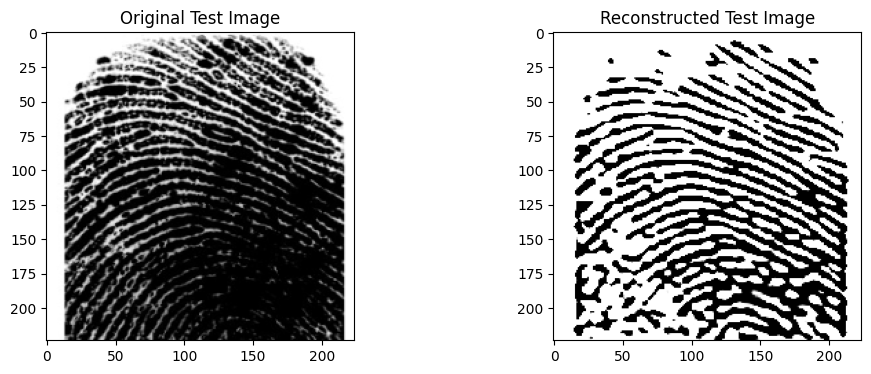

In [ ]:
# Display the original and reconstructed test images
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Test Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_test_image, cmap='gray')
plt.title('Reconstructed Test Image')
plt.show()

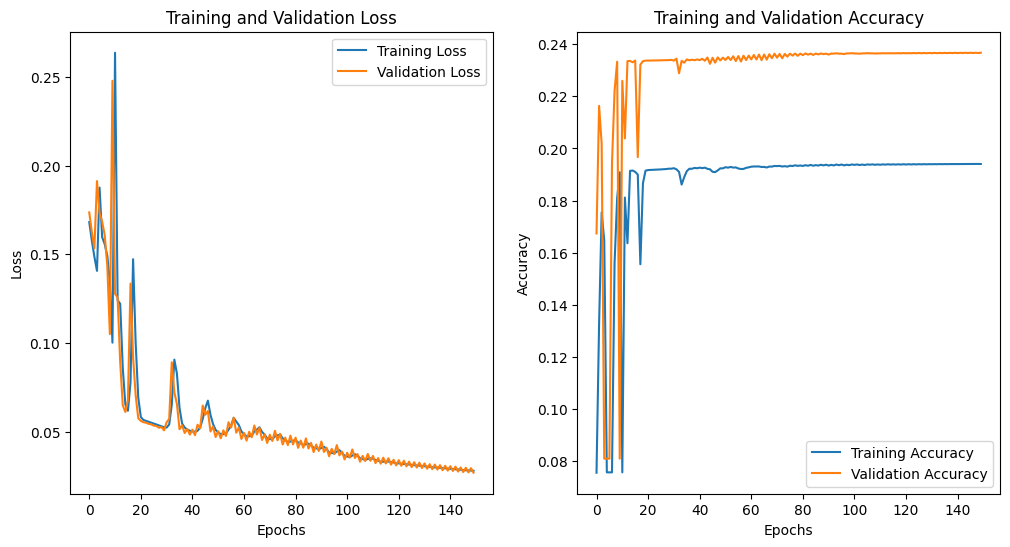

In [ ]:
# Plot the training and validation loss (reconstruction error) and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()